### Importing modules

In [23]:
import pydot
from IPython.display import Image, display
from sympy.interactive import printing
printing.init_printing(use_latex=True)
import networkx as nx
import matplotlib.pyplot as plt
import copy

### BFS

In [2]:
#shortest path
def find_shortest_path(graph, start, end, path=[]):
    path = path + [start]
    if start == end:
        return path
    if start not in graph: #or graph.__contains__(start)
        return None
    shortest = None
    for node in graph[start]:
        if node not in path:
            newpath = find_shortest_path(graph, node, end, path)
            if newpath:
                if not shortest or len(newpath) < len(shortest):
                    shortest = newpath
    return shortest

### Basic drawing fun

In [3]:
def drawing_nx (dic):
    G=nx.Graph()
    for key, value in dic.items():
        for i in range(len(value)):
            G.add_edge(key,value[i])
    posit=nx.planar_layout(G)
    nx.draw(G, posit, with_labels=True)
    plt.show()

### Graph to color

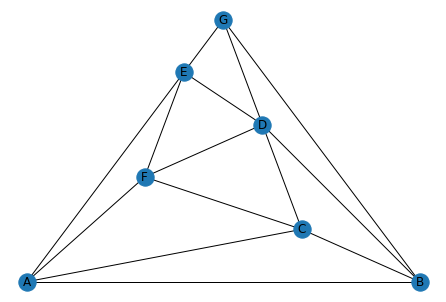

In [25]:
graph1 = {'A': ['B', 'C'],
         'B': ['C', 'D'],
         'C': ['D'],
         'D': ['C','G'],
         'E': ['A','F','D'],
         'F': ['A','C','D'],
         'G':['B','D','E']}
drawing_nx(graph1)

In [5]:
def adjlisting(dic):
    '''correct dictionary if defined manually - make sure all edges are there'''
    G=nx.Graph()
    for key, value in dic.items():
        for i in range(len(value)):
            G.add_edge(key,value[i])
    M=nx.to_dict_of_lists(G)
    return M

In [6]:
def nxgraphmaker(dic):
    '''creats nx.Graph object from adjacency dictionary'''
    G=nx.Graph()
    for key, value in dic.items():
        for i in range(len(value)):
            G.add_edge(key,value[i])
    return G

In [7]:
def subG (dic,node5d):
    '''creates a subgraph of the 5-deg node and its neighbors'''
    G=nxgraphmaker(dic)
    nodeList=[nei for nei in G.neighbors(node5d)]
    nodeList.append(node5d)
    subGraph=G.subgraph(nodeList)
    return subGraph

### Get ordered neighbor list of the 5-degree node

In [20]:
def ordering_neibs(dic,node5d):
    '''return order (cw or ccw) of neighbors of the 5deg node
    Important is that they are connected to each other in that order'''
    sub=subG(dic=dic,node5d=node5d)
    ordered_list=[]
    visited_list=[node5d]
    centerNode=node5d
    for i in range(len(list(sub.neighbors(node5d)))): #itterate x-time (x=num of neibs)
        j=0
        while list(sub.neighbors(centerNode))[j] in visited_list:
            j+=1
            if j==len(list(sub.neighbors(centerNode))):
                return ordered_list
        being_visited=list(sub.neighbors(centerNode))[j]
        ordered_list.append(being_visited)
        visited_list.append(being_visited)
        centerNode=being_visited
    print("Ordering of neighbors of {}: {}".format(node5d,ordered_list))
    return ordered_list

### Planarity check

**Theorem**: *(Euler's Formula)* For a connected planar simple graph $G=(V,E)$ with $e=|E|$ and $v=|V|$, if we let r be the number of regions that are created when drawing a planar representation of the graph, then $r=e−v+2$.

Proof idea: We proceed by induction on the number of edges. For $e=1$, we can only have this graph, which has $v=2$ and $r=1$, so the theorem holds.


If we assume the conclusion for $e−1$ edges, and add an edge to get our planar graph, there are only two possibilities to consider.

Case 1: we add a pendant vertex and edge. In this case e and v both increase by one and the equality still holds.


Case 2: we add an edge across two existing vertices (that doesn't cross any other edges, of course). Here, r and e both increase by one, preserving the equality.


So we can build any planar graph with $e$ edges and it will always have $r=e−v+2$.

**Theorem**: For a simple connected planar graph with $v\geq 3$ vertices and $e$ edges, $e\leq3v−6$.

Proof: Let $r$ be the number of regions in a planar representation of the graph, and for a region $R$, let $deg(R)$ be the number of edges that are adjacent to the region, so each edge is adjacent to two regions.

We know that $deg(R)\geq3$ for each region since the graph doesn't have multiple edges (for interior regions) and has at least three vertices (for the exterior region). Since each edge is adjacent to two regions, $2e=\sum deg(R)\geq3r$.

We can use this with Euler's formula $(r=e−v+2)$ to get
$$3r \leq 2e$$
$$3(e-v+2) \leq 2e$$
$$e \leq 3v-6$$
          
**Corallary**: A simple connected planar graph with v≥3 has a vertex of degree five or less.

Proof: Suppose every vertex has degree 6 or more. Then the total number of edges is 2e≥6v. But, because the graph is planar,
          $$\sum \deg(v)=2e≤6v−12$$

which is a contradiction.

In [9]:
def planarityCheck(dic):
    '''check whether graph is planar (dict input);
    can use without adjlisting'''
    G=nxgraphmaker(dic=dic)
    is_planar=nx.algorithms.planarity.check_planarity(G)[0]
    return is_planar

### Color swap

In [10]:
def col_swaper (dic,orderedNeibs,col_labels):
    '''col_labels is dictionary {node:color} created during in coloring()'''
    G=nxgraphmaker(dic)
    w_1and3=[col_labels[orderedNeibs[0]],col_labels[orderedNeibs[2]] ]
    w_2and4=[col_labels[orderedNeibs[1]],col_labels[orderedNeibs[3]] ]
    collist=[w_1and3,w_2and4]
    
    #need to check only one pair - if the first if connected, then automatically take second
    nodelist=[]
    for node, color in col_labels.items():
        if color in collist[0]:
            nodelist.append(node)
    subColors=G.subgraph(nodelist)
    subDict=nx.to_dict_of_lists(subColors)
    answer=find_shortest_path(graph=subDict,start=orderedNeibs[0],end=orderedNeibs[2]) #BFS variant
    if not answer:
        answer=[orderedNeibs[0],orderedNeibs[2]]
    else:
        answer=[orderedNeibs[1],orderedNeibs[3]]
    new_col_labels=copy.deepcopy(col_labels) #the answer give the pair of vertices for color-swap
    new_col_labels[answer[0]]=col_labels[answer[1]]
    new_col_labels[answer[1]]=col_labels[answer[0]]
    return new_col_labels

### Final 5-coloring function

**Definition:** A coloring of a graph maps the vertices to colors, such that if 2 vertices are connected by an edge, they don't have the same color. We call $n$ the size of a coloring, and if $G$ has a coloring of size $n$ we say that $G$ is $n$-colorable.

**Definition:** The chromatic number of a graph $G$, denoted $\chi(G)$ is the smallest positive number $k$ such that $G$ is $k$-colorable.

**Theorem:** Every planar graph admits a 5-coloring.

In [16]:
def coloring(dic,colors=None):
    adjlist=adjlisting(dic=dic) #to be sure all neighbors are listed with each node
    if planarityCheck(dic=adjlist):
        print("The graph is planar.")
    else:
        return("Not planar, can't do.")
    if not colors:
        colors=['lightblue','pink','green','red','purple']
    for value in adjlist.values(): #neighbors in ascending order 
        value.sort()
        
    col_labels={}
    for key, value in adjlist.items():
        if len(value)<5:#if less than 5 neighbors
            if key not in col_labels:
                col_labels.__setitem__(key,"")
            options=copy.deepcopy(colors)
            for col in options:
            
                if not col_labels[key]:       #if the graph is connected,
                                              # only the first node will be found empty - the others will be neighbors
                    col_labels[key]=min(options) #get it one by one alphabetically
                    #print(options) 
                    options.remove(min(options))
                    #print(options)
                for neib in value:
                    if neib not in col_labels:
                        col_labels.__setitem__(neib,"")
                    if not col_labels[neib]:
                        col_labels[neib]=min(options)
                        options.remove(min(options))
        if len(value)==5: #the vertex of degree=5
            node5d=key #coloring will be rearanged around this node
    
    orderedNeibs=ordering_neibs(dic=adjlist,node5d=node5d) #ordering neighbors of the 5deg node
    col_labels=col_swaper(dic=adjlist,orderedNeibs=orderedNeibs,col_labels=col_labels) #changing colors between w1 and w3 (or w2 and w4)
        #inside col_swaper implement bfs/connect check:create subgraph of 2 colors, check whether the nodes w1 and w3 in this subG are connected
    G=nxgraphmaker(adjlist)
    posit=nx.planar_layout(G)
    nx.draw(G, posit,node_color=col_labels.values(), with_labels=True)
    plt.show()      

The graph is planar.
Ordering of neighbors of D: ['B', 'C', 'F', 'E', 'G']


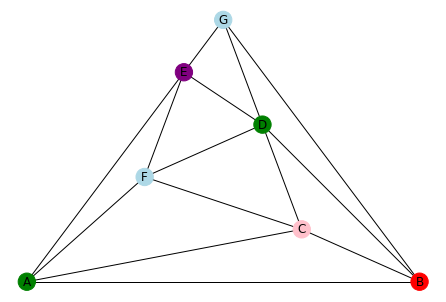

In [21]:
coloring(graph1)